# Analysis of the potential locations for consumer business in Moscow, Russia.

## Table of contents

* [1. Introduction](#introduction)
* [2. Data](#data)
* [3. Methodology](#methodology)
* [4. Data analysis](#analysis)
   - [4.1 Libraries](#libraries)
   - [4.2 Subway stations data from wikipedia.org](#wiki)
   - [4.3 Add traffic data to stations list](#traffic)
   - [4.4 Create a map of Moscow ](#map)
   - [4.5 Foursquare](#foursquare)
   - [4.6 Pharmacies](#pharmacies)
   - [4.7 Add other venues number to 'no pharmacies' list](#number)
   - [4.8 Plotting station traffic and venues number](#plot)
   - [4.9 Clustering](#clustering)
* [5. Results](#Results)
* [6. Discussion](#discussion)
* [7. Conclusion](#conclusion)

## 1. Introduction <a name="introduction"></a>

Search for the most profitable locations to open a new business in **Moscow**,Russia. Where to open a pharmacy or a convinient shop? Where passability and competitive environment are the most profitable?
Moscow metro serves an average of 10 million passengers a day. Thus there are certain places what customers passes every day. 
Using foursquare data we will find out the best places for new customer business startup.
This analysis will be interesting for retail business stakeholders.

## 2. Data <a name="data"></a>


1. Moscow subway stations list with coordinates from wikipedia. https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations#List_of_active_stations
2. Passenger traffic data.
3. Foursquare data about existing venues near Moscow subway stations.

Subway station coordinates will be downloaded, correlated with passenger traffic data. Then existing venues will be analysed.
Clasterisation will be provided for subway station using its nearby venues.

## 3. Methodology <a name="methodology"></a> 

Moscow subway passenger traffic is an average 10 million passengers a day. Accordingly, metro stations are points of attraction in the city. To determine the most effective places for retail business, take the location of metro stations and retail facilities within 200 meters from the stations. This is the distance that passengers can go without significant loss of time to buy the necessary goods.  

The technique is suitable for all types of retail. In this analysis, we will give an example for pharmacies. 

* The first step is to **download the list of metro stations** and its coordinates. It will be taken from the Wikipedia page. Add to the list of stations data on passenger traffic. 

* We will draw a **map of Moscow** and the metro stations on it.

* With Foursquare we will find all the **objects within 200 meters** from the stations. For this analysis, we choose only pharmacies.  

* Let's define a list of stations where there are **no pharmacies**.  

* We will **cluster** (using k-means clustering) stations without pharmacies according to two parameters: passenger traffic and the number of objects nearby.  

* We will make significant **conclusions** for business on the results of clustering.

## 4. Data analysis <a name="analysis"></a>

First step is to download Moscow subway stations list with coordinates using **requests library** from **wikipedia.org** page https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations.

### 4.1 Libraries <a name="libraries"></a>

In [1]:
import pandas as pd
import numpy as np
import requests

from bs4 import BeautifulSoup

Libraries are imported.


### 4.2 Subway stations data from wikipedia.org <a name="wiki"></a>

In [3]:
#Download data from wikipedia page
source = requests.get('https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations#List_of_active_stations').text
soup = BeautifulSoup(source,'lxml')

In [4]:
#Checking page title
file_title = soup.title.text
print(file_title)

List of Moscow Metro stations - Wikipedia


In [90]:
#Taking table data
table = soup.find('table', class_ = 'wikitable sortable') 
#print(table.prettify())

In [6]:
# Taking data from the table with checking last column. Some lines contains 8 cells, some 7. We need only first 7 cells in each row
table_np = []
for tr in table.find_all('tr'):
    i=0
    for span in tr.find_all('span'):
        span_str = span.get('title') 
        if (span_str is not None) and (span_str != 'Russian language text') and (span_str != 'Maps, aerial photos, and other data for this location'):
            if span_str[0] == '#':
                table_np.append(span_str)
    for td in tr.find_all('td'):
        if (i<7):
            table_np.append(td.text.rstrip('\n'))
        i = i+1

In [7]:
#Checking what we have downloaded
if len(table_np)%8 == 0: print('True')
table_np[0:8]

True


['#1 Sokolnicheskaya line',
 'Bulvar Rokossovskogo',
 'Бульвар Рокоссовского',
 '<>',
 '1990-08-01',
 '−8 m',
 'column, triple-span',
 '55°48′53″N 37°44′03″E\ufeff / \ufeff55.8148°N 37.7342°E\ufeff / 55.8148; 37.7342\ufeff (Bulvar Rokossovskogo (Sokolnicheskaya line))']

In [8]:
#Creating a pandas dataframe for downloaded data
column_names = ['Line','Station','Station_Ru', 'Transfer', 'Opened','Elevation', 'Type', 'Coordinates'] 
subway = pd.DataFrame(columns=column_names)

In [9]:
#Filling the dataframe

for j in range(len(table_np)-1):
    if (j%8 == 0):  # Taking every 8 cells from 1 dimension numpy array
        Line = table_np[j]
        Station = table_np[j+1]
        Station_Ru = table_np[j+2]
        Transfer = table_np[j+3]
        Opened = table_np[j+4]
        Elevation = table_np[j+5]
        Type = table_np[j+6]
        Coordinates = table_np[j+7]
        subway = subway.append({'Line' : Line,
                                'Station': Station,   # Add row to the dataframe
                                'Station_Ru': Station_Ru,
                                'Transfer' : Transfer,
                                'Opened' : Opened,
                                'Elevation' : Elevation,
                                'Type' : Type,
                                'Coordinates': Coordinates}, ignore_index=True)

In [10]:
subway.shape

(264, 8)

In [11]:
subway.head()

,Line,Station,Station_Ru,Transfer,Opened,Elevation,Type,Coordinates
0,#1 Sokolnicheskaya line,Bulvar Rokossovskogo,Бульвар Рокоссовского,<>,1990-08-01,−8 m,"column, triple-span",55°48′53″N 37°44′03″E﻿ / ﻿55.8148°N 37.7342°E﻿...
1,#1 Sokolnicheskaya line,Cherkizovskaya,Черкизовская,{},1990-08-01,−9 m,"single-vault, shallow",55°48′14″N 37°44′41″E﻿ / ﻿55.8038°N 37.7448°E﻿...
2,#1 Sokolnicheskaya line,Preobrazhenskaya Ploshchad,Преображенская площадь,,1965-12-31,−8 m,"column, triple-span",55°47′47″N 37°42′54″E﻿ / ﻿55.7963°N 37.7151°E﻿...
3,#1 Sokolnicheskaya line,Sokolniki,Сокольники,,1935-05-15,−9 m,"column, triple-span",55°47′20″N 37°40′49″E﻿ / ﻿55.7888°N 37.6802°E﻿...
4,#1 Sokolnicheskaya line,Krasnoselskaya,Красносельская,,1935-05-15,−8 m,"column, double-span",55°46′48″N 37°40′02″E﻿ / ﻿55.7801°N 37.6673°E﻿...


In [12]:
#Select latitude and longitude data from Coordinates column
for i in range(len(subway)):
    s = subway.loc[i,'Coordinates']
    beg = subway.loc[i,'Coordinates'].find('/ ')
    end = subway.loc[i,'Coordinates'].find('°N')
    subway.at[i,'Latitude'] = s[beg+3:beg+10]
    subway.at[i,'Longitude'] = s[end+3:end+10]
    StationID = subway.loc[i,'Station'] +' Line '+ subway.loc[i,'Line'][0:3]
    subway.at[i,'StationID'] = StationID.rstrip()

In [13]:
subway.head()

,Line,Station,Station_Ru,Transfer,Opened,Elevation,Type,Coordinates,Latitude,Longitude,StationID
0,#1 Sokolnicheskaya line,Bulvar Rokossovskogo,Бульвар Рокоссовского,<>,1990-08-01,−8 m,"column, triple-span",55°48′53″N 37°44′03″E﻿ / ﻿55.8148°N 37.7342°E﻿...,55.8148,37.7342,Bulvar Rokossovskogo Line #1
1,#1 Sokolnicheskaya line,Cherkizovskaya,Черкизовская,{},1990-08-01,−9 m,"single-vault, shallow",55°48′14″N 37°44′41″E﻿ / ﻿55.8038°N 37.7448°E﻿...,55.8038,37.7448,Cherkizovskaya Line #1
2,#1 Sokolnicheskaya line,Preobrazhenskaya Ploshchad,Преображенская площадь,,1965-12-31,−8 m,"column, triple-span",55°47′47″N 37°42′54″E﻿ / ﻿55.7963°N 37.7151°E﻿...,55.7963,37.7151,Preobrazhenskaya Ploshchad Line #1
3,#1 Sokolnicheskaya line,Sokolniki,Сокольники,,1935-05-15,−9 m,"column, triple-span",55°47′20″N 37°40′49″E﻿ / ﻿55.7888°N 37.6802°E﻿...,55.7888,37.6802,Sokolniki Line #1
4,#1 Sokolnicheskaya line,Krasnoselskaya,Красносельская,,1935-05-15,−8 m,"column, double-span",55°46′48″N 37°40′02″E﻿ / ﻿55.7801°N 37.6673°E﻿...,55.7801,37.6673,Krasnoselskaya Line #1


In [14]:
#Changing data type from string to float for Latitude and Longitude
subway['Latitude']= pd.to_numeric(subway['Latitude'])
subway['Longitude']= pd.to_numeric(subway['Longitude'])

In [15]:
subway.shape

(264, 11)

### 4.3 Add traffic data to stations list  <a name="traffic"></a>

In [16]:
#Download traffic data from excel file

traffic = pd.read_excel('passazhiropotok-metro2017.xlsx')
traffic.head()

,StationID,Line,Station,Traffic
0,Arbatskaya Line #3,Line #3,Arbatskaya,59491
1,Baumanskaya Line #3,Line #3,Baumanskaya,65635
2,Izmaylovskaya Line #3,Line #3,Izmaylovskaya,40289
3,Partizanskaya Line #3,Line #3,Partizanskaya,55937
4,Kiyevskaya Line #3,Line #3,Kiyevskaya,57294


In [17]:
traffic.shape

(160, 4)

In [18]:
#Making new column for traffic data in subway dataframe
subway['Traffic'] = 0

In [19]:
#Adding traffic data to main dataframe subway

In [20]:
for i in range(len(subway)):
    for j in range(len(traffic)):
        if (traffic.loc[j,'StationID'] == subway.loc[i,'StationID']):
            subway.loc[i,'Traffic'] = traffic.loc[j,'Traffic']
               

In [21]:
subway.head(3)

,Line,Station,Station_Ru,Transfer,Opened,Elevation,Type,Coordinates,Latitude,Longitude,StationID,Traffic
0,#1 Sokolnicheskaya line,Bulvar Rokossovskogo,Бульвар Рокоссовского,<>,1990-08-01,−8 m,"column, triple-span",55°48′53″N 37°44′03″E﻿ / ﻿55.8148°N 37.7342°E﻿...,55.8148,37.7342,Bulvar Rokossovskogo Line #1,445
1,#1 Sokolnicheskaya line,Cherkizovskaya,Черкизовская,{},1990-08-01,−9 m,"single-vault, shallow",55°48′14″N 37°44′41″E﻿ / ﻿55.8038°N 37.7448°E﻿...,55.8038,37.7448,Cherkizovskaya Line #1,94676
2,#1 Sokolnicheskaya line,Preobrazhenskaya Ploshchad,Преображенская площадь,,1965-12-31,−8 m,"column, triple-span",55°47′47″N 37°42′54″E﻿ / ﻿55.7963°N 37.7151°E﻿...,55.7963,37.7151,Preobrazhenskaya Ploshchad Line #1,70553


 ### 4.4 Create a map of Moscow <a name="map"></a>

In [22]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [30]:
#Download latitude and longitude for city map
address = 'Moscow, Russia'

geolocator = Nominatim(user_agent="m_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Moscow are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Moscow are 55.7504461, 37.6174943.


In [31]:
#Create a map
map_moscow = folium.Map(location=[latitude, longitude], zoom_start=10)

In [32]:
#Add subway stations marks to Moscow map
for lat, lng, station in zip(subway['Latitude'], subway['Longitude'], subway['Station']):
    label = station
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)  

In [33]:
#Show map
map_moscow

### 4.5 Foursquare <a name="foursquare"></a>

Now we will download all venues in 200 meters radius near stations usinf Foursquare.

In [34]:
CLIENT_ID = 'DGKYEQMKZGFLSASBFJOWQ21U53VX41HQKR4GW3AW2MWR153D' # your Foursquare ID
CLIENT_SECRET = 'MQ0P0SE1DC2I23VF022F0DGFKQFXFDU2P4TMXTDSBTJCK3YG' # your Foursquare Secret
VERSION = '20190711' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DGKYEQMKZGFLSASBFJOWQ21U53VX41HQKR4GW3AW2MWR153D
CLIENT_SECRET:MQ0P0SE1DC2I23VF022F0DGFKQFXFDU2P4TMXTDSBTJCK3YG


In [35]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [36]:
#Create a fuction that download all venues in 200 meters radius from input point on the map
LIMIT = 400
def getNearbyVenues(ids, names, latitudes, longitudes, radius=200):
    
    venues_list=[]
    for stationid, name, lat, lng in zip(ids, names, latitudes, longitudes):
 #       print(stationid)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            stationid,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['StationID','Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [41]:
#Download Moscow venues 
moscow_venues = getNearbyVenues(ids=subway['StationID'],
                                names=subway['Station'],
                                latitudes=subway['Latitude'],
                                longitudes=subway['Longitude']
                                )

In [42]:
moscow_venues.head()

,StationID,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bulvar Rokossovskogo Line #1,Bulvar Rokossovskogo,55.8148,37.7342,Ветеринарная Аптека Ветлек,55.813464,37.735036,Pet Store
1,Bulvar Rokossovskogo Line #1,Bulvar Rokossovskogo,55.8148,37.7342,Фо & Ролл,55.815955,37.736421,Vietnamese Restaurant
2,Bulvar Rokossovskogo Line #1,Bulvar Rokossovskogo,55.8148,37.7342,Подружка,55.814523,37.736781,Cosmetics Shop
3,Bulvar Rokossovskogo Line #1,Bulvar Rokossovskogo,55.8148,37.7342,Галерея Богородское,55.813944,37.734298,Art Gallery
4,Bulvar Rokossovskogo Line #1,Bulvar Rokossovskogo,55.8148,37.7342,Бургер Кинг,55.814026,37.733659,Burger Joint


In [43]:
moscow_venues.shape

(3364, 8)

### 4.6 Pharmacies <a name="pharmacies"></a>
From venues list we will chose pharmacies. Then split stations list for two: with and without pharmacies.
Sorting "no pharmacies" list descending. 

In [44]:
#We can chose any category for further analysis. In this sample I have chosen pharmacies.
pharmacy = moscow_venues[moscow_venues['Venue Category'] == 'Pharmacy']
pharmacy.head()

,StationID,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
33,Preobrazhenskaya Ploshchad Line #1,Preobrazhenskaya Ploshchad,55.7963,37.7151,"36,6",55.795907,37.713681,Pharmacy
108,Krasnye Vorota Line #1,Krasnye Vorota,55.7690,37.6487,Ригла,55.768066,37.646288,Pharmacy
205,Park Kultury Line #1,Park Kultury,55.7356,37.5943,Эвалар,55.735856,37.592643,Pharmacy
230,Frunzenskaya Line #1,Frunzenskaya,55.7267,37.5786,Аптеки Столицы № 3,55.724965,37.578963,Pharmacy
272,Universitet Line #1,Universitet,55.6926,37.5333,A.v.e.,55.693219,37.534291,Pharmacy


In [45]:
pharmacy_station = pharmacy[['StationID', 'Station', 'Station Latitude', 'Station Longitude']].drop_duplicates()
print(pharmacy_station.shape)

(49, 4)


In [46]:
pharmacy_station.head()
# pharmacy_station - list of stations with parmacies nearby

,StationID,Station,Station Latitude,Station Longitude
33,Preobrazhenskaya Ploshchad Line #1,Preobrazhenskaya Ploshchad,55.7963,37.7151
108,Krasnye Vorota Line #1,Krasnye Vorota,55.7690,37.6487
205,Park Kultury Line #1,Park Kultury,55.7356,37.5943
230,Frunzenskaya Line #1,Frunzenskaya,55.7267,37.5786
272,Universitet Line #1,Universitet,55.6926,37.5333


In [47]:
#Reset index of the new dataframe
pharmacy_station.reset_index(drop=True, inplace=True)
pharmacy_station.head()

,StationID,Station,Station Latitude,Station Longitude
0,Preobrazhenskaya Ploshchad Line #1,Preobrazhenskaya Ploshchad,55.7963,37.7151
1,Krasnye Vorota Line #1,Krasnye Vorota,55.7690,37.6487
2,Park Kultury Line #1,Park Kultury,55.7356,37.5943
3,Frunzenskaya Line #1,Frunzenskaya,55.7267,37.5786
4,Universitet Line #1,Universitet,55.6926,37.5333


In [48]:
#Add pharmacy flag to subway dataframe
subway['Pharmacy'] = 0
for i in range(len(subway)):
    for j in range(len(pharmacy_station)):
        if (subway.loc[i,'StationID'] == pharmacy_station.loc[j,'StationID']):
            subway.loc[i,'Pharmacy'] = 1
subway.head()

,Line,Station,Station_Ru,Transfer,Opened,Elevation,Type,Coordinates,Latitude,Longitude,StationID,Traffic,Pharmacy
0,#1 Sokolnicheskaya line,Bulvar Rokossovskogo,Бульвар Рокоссовского,<>,1990-08-01,−8 m,"column, triple-span",55°48′53″N 37°44′03″E﻿ / ﻿55.8148°N 37.7342°E﻿...,55.8148,37.7342,Bulvar Rokossovskogo Line #1,445,0
1,#1 Sokolnicheskaya line,Cherkizovskaya,Черкизовская,{},1990-08-01,−9 m,"single-vault, shallow",55°48′14″N 37°44′41″E﻿ / ﻿55.8038°N 37.7448°E﻿...,55.8038,37.7448,Cherkizovskaya Line #1,94676,0
2,#1 Sokolnicheskaya line,Preobrazhenskaya Ploshchad,Преображенская площадь,,1965-12-31,−8 m,"column, triple-span",55°47′47″N 37°42′54″E﻿ / ﻿55.7963°N 37.7151°E﻿...,55.7963,37.7151,Preobrazhenskaya Ploshchad Line #1,70553,1
3,#1 Sokolnicheskaya line,Sokolniki,Сокольники,,1935-05-15,−9 m,"column, triple-span",55°47′20″N 37°40′49″E﻿ / ﻿55.7888°N 37.6802°E﻿...,55.7888,37.6802,Sokolniki Line #1,59133,0
4,#1 Sokolnicheskaya line,Krasnoselskaya,Красносельская,,1935-05-15,−8 m,"column, double-span",55°46′48″N 37°40′02″E﻿ / ﻿55.7801°N 37.6673°E﻿...,55.7801,37.6673,Krasnoselskaya Line #1,26347,0


In [49]:
#Chosing stations without pharmacies nearby
no_pharmacy = subway[subway['Pharmacy'] == 0]
no_pharmacy.reset_index(drop=True, inplace=True)

In [50]:
no_pharmacy = no_pharmacy.drop(['Station_Ru', 'Transfer', 'Elevation', 'Type', 'Coordinates', 'Pharmacy'], axis=1)

In [51]:
no_pharmacy.shape
no_pharmacy.head()

,Line,Station,Opened,Latitude,Longitude,StationID,Traffic
0,#1 Sokolnicheskaya line,Bulvar Rokossovskogo,1990-08-01,55.8148,37.7342,Bulvar Rokossovskogo Line #1,445
1,#1 Sokolnicheskaya line,Cherkizovskaya,1990-08-01,55.8038,37.7448,Cherkizovskaya Line #1,94676
2,#1 Sokolnicheskaya line,Sokolniki,1935-05-15,55.7888,37.6802,Sokolniki Line #1,59133
3,#1 Sokolnicheskaya line,Krasnoselskaya,1935-05-15,55.7801,37.6673,Krasnoselskaya Line #1,26347
4,#1 Sokolnicheskaya line,Komsomolskaya,1935-05-15,55.7753,37.6562,Komsomolskaya Line #1,69523


### 4.7 Add other venues number to 'no pharmacies' list <a name="number"></a>

In [52]:
#Venues count for stations without pharmacies
m = moscow_venues.groupby('StationID').count()
m.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
StationID,,,,,,,
Aeroport Line #2,25,25,25,25,25,25,25
Akademicheskaya Line #6,18,18,18,18,18,18,18
Aleksandrovsky Sad Line #4,18,18,18,18,18,18,18
Alekseyevskaya Line #6,23,23,23,23,23,23,23
Alma-Atinskaya Line #2,4,4,4,4,4,4,4


In [53]:
for i in range(len(no_pharmacy)):
    for j in m.index:
        if (no_pharmacy.loc[i,'StationID'] == j):
            no_pharmacy.loc[i,'Venues count'] = m.loc[j,'Station']
no_pharmacy.head()
#Список станций метро, у которых нет аптеки в пределах 200 метров с подсчитанным количеством других объектов

,Line,Station,Opened,Latitude,Longitude,StationID,Traffic,Venues count
0,#1 Sokolnicheskaya line,Bulvar Rokossovskogo,1990-08-01,55.8148,37.7342,Bulvar Rokossovskogo Line #1,445,11.0
1,#1 Sokolnicheskaya line,Cherkizovskaya,1990-08-01,55.8038,37.7448,Cherkizovskaya Line #1,94676,10.0
2,#1 Sokolnicheskaya line,Sokolniki,1935-05-15,55.7888,37.6802,Sokolniki Line #1,59133,37.0
3,#1 Sokolnicheskaya line,Krasnoselskaya,1935-05-15,55.7801,37.6673,Krasnoselskaya Line #1,26347,17.0
4,#1 Sokolnicheskaya line,Komsomolskaya,1935-05-15,55.7753,37.6562,Komsomolskaya Line #1,69523,6.0


In [54]:
#no_pharmacy[no_pharmacy['Venues count'] == 'Nan']

no_pharmacy.replace(np.nan, 0, inplace=True)

In [55]:
no_pharmacy.sort_values(by='Traffic', ascending=False, inplace = True)
no_pharmacy.reset_index(drop=True, inplace=True)
no_pharmacy.head(10)

,Line,Station,Opened,Latitude,Longitude,StationID,Traffic,Venues count
0,#5 Koltsevaya line,Komsomolskaya,1952-01-30,55.7748,37.6549,Komsomolskaya Line #5,187078,5.0
1,#7 Tagansko-Krasnopresnenskaya line,Vykhino,1966-12-31,55.7156,37.8181,Vykhino Line #7,176629,5.0
2,#1 Sokolnicheskaya line,Yugo-Zapadnaya,1963-12-30,55.6637,37.4833,Yugo-Zapadnaya Line #1,128629,33.0
3,#2 Zamoskvoretskaya line,Rechnoy Vokzal,1964-12-31,55.8549,37.4761,Rechnoy Vokzal Line #2,121187,26.0
4,#7 Tagansko-Krasnopresnenskaya line,Tekstilshchiki,1966-12-31,55.7088,37.7316,Tekstilshchiki Line #7,118849,14.0
5,#9 Serpukhovsko-Timiryazevskaya line,Prazhskaya,1985-11-06,55.6124,37.6044,Prazhskaya Line #9,118271,38.0
6,#9 Serpukhovsko-Timiryazevskaya line,Petrovsko-Razumovskaya,1991-03-01,55.8351,37.5745,Petrovsko-Razumovskaya Line #9,116079,9.0
7,#7 Tagansko-Krasnopresnenskaya line,Pushkinskaya,1975-12-17,55.7650,37.6079,Pushkinskaya Line #7,109983,27.0
8,#2 Zamoskvoretskaya line,Tsaritsyno,1984-12-30,55.6214,37.6694,Tsaritsyno Line #2,96381,14.0
9,#3 Arbatsko-Pokrovskaya line,Ploshchad Revolyutsii,1938-03-13,55.7566,37.6216,Ploshchad Revolyutsii Line #3,96283,20.0


In [56]:
print('Количество станций метро без аптеки в шаговой доступности', len(no_pharmacy))

Количество станций метро без аптеки в шаговой доступности 215


### 4.8 Plotting station traffic and venues number <a name="plot"></a>

In [57]:
#Нарисуем график трафика и количества объектов для станций без аптеки

In [58]:
from matplotlib import pyplot as plt 
%matplotlib inline

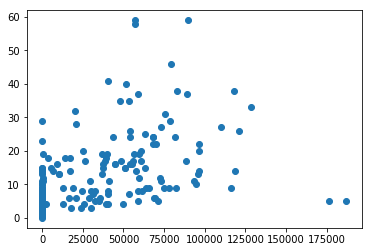

In [59]:
plt.scatter(no_pharmacy['Traffic'], no_pharmacy['Venues count'], marker='o') 

In [60]:
#Убираем дубликаты из списка объектов.
moscow_drop = moscow_venues.drop_duplicates(subset=['Venue Latitude','Venue Longitude', 'Venue'])
moscow_drop.shape
#moscow_drop.to_excel('venues2.xlsx')

(2751, 8)

In [61]:
#Вот теперь над no_pharmacy мы и будем делать кластеризацию. С надеждой на объяснимый результат.
#Ура!

### 4.9 Clustering <a name="clustering"></a>

In [62]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

# Taking traffic and venues density data for clustering
moscow_clustering = no_pharmacy[['Traffic','Venues count']]
moscow_clustering.head()

,Traffic,Venues count
0,187078,5.0
1,176629,5.0
2,128629,33.0
3,121187,26.0
4,118849,14.0


In [87]:
from sklearn.preprocessing import StandardScaler

X = moscow_clustering.values[:,0:]
X = np.nan_to_num(X)

Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet[0:5]

array([[ 4.33501764, -0.62167474],
       [ 4.04885774, -0.62167474],
       [ 2.73431326,  1.96469839],
       [ 2.5305041 ,  1.31810511],
       [ 2.46647483,  0.20965948]])

In [88]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30] 

array([3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 2, 2, 1, 1,
       2, 1, 2, 2, 2, 2, 2, 2])

In [89]:
no_pharmacy['Cluster'] = kmeans.labels_
no_pharmacy.head(10)

,Line,Station,Opened,Latitude,Longitude,StationID,Traffic,Venues count,Cluster
0,#5 Koltsevaya line,Komsomolskaya,1952-01-30,55.7748,37.6549,Komsomolskaya Line #5,187078,5.0,3
1,#7 Tagansko-Krasnopresnenskaya line,Vykhino,1966-12-31,55.7156,37.8181,Vykhino Line #7,176629,5.0,3
2,#1 Sokolnicheskaya line,Yugo-Zapadnaya,1963-12-30,55.6637,37.4833,Yugo-Zapadnaya Line #1,128629,33.0,3
3,#2 Zamoskvoretskaya line,Rechnoy Vokzal,1964-12-31,55.8549,37.4761,Rechnoy Vokzal Line #2,121187,26.0,3
4,#7 Tagansko-Krasnopresnenskaya line,Tekstilshchiki,1966-12-31,55.7088,37.7316,Tekstilshchiki Line #7,118849,14.0,3
5,#9 Serpukhovsko-Timiryazevskaya line,Prazhskaya,1985-11-06,55.6124,37.6044,Prazhskaya Line #9,118271,38.0,1
6,#9 Serpukhovsko-Timiryazevskaya line,Petrovsko-Razumovskaya,1991-03-01,55.8351,37.5745,Petrovsko-Razumovskaya Line #9,116079,9.0,3
7,#7 Tagansko-Krasnopresnenskaya line,Pushkinskaya,1975-12-17,55.7650,37.6079,Pushkinskaya Line #7,109983,27.0,3
8,#2 Zamoskvoretskaya line,Tsaritsyno,1984-12-30,55.6214,37.6694,Tsaritsyno Line #2,96381,14.0,3
9,#3 Arbatsko-Pokrovskaya line,Ploshchad Revolyutsii,1938-03-13,55.7566,37.6216,Ploshchad Revolyutsii Line #3,96283,20.0,3


In [72]:
# Define colours for clusters
colors = ['red','blue','green','yellow','purple','black','gray','indigo','orange','olive']
colors_array = []

for k in range(len(no_pharmacy)):
    colors_array.append(colors[no_pharmacy.loc[k,'Cluster']])
colors_array[0:10]

['yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'blue',
 'yellow',
 'yellow',
 'yellow',
 'yellow']

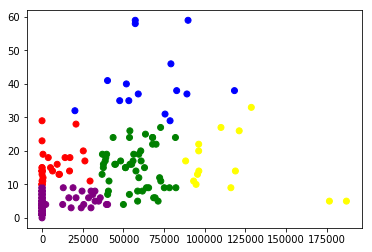

In [73]:
# Plotting clusterisation resuls
plt.scatter(no_pharmacy['Traffic'], no_pharmacy['Venues count'], marker='o', c=colors_array) 

In [74]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lon, poi, cluster in zip(no_pharmacy['Latitude'], no_pharmacy['Longitude'], no_pharmacy['StationID'],no_pharmacy['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.5).add_to(map_clusters)     

map_clusters

##  5. Results  <a name="results"></a>

As a result of the clustering 5 clusters are allocated. The most promising are clusters numbered 3 (yellow), 14 stations and 1 (blue), 15 stations. These clusters combine the most passable stations, and differ in the density of other objects around.

In [82]:
clusters = no_pharmacy.groupby('Cluster').mean()
clusters['Color'] = colors[0:len(clusters)]
clusters['Num of Stations'] = no_pharmacy.groupby('Cluster').count()['Line']
clusters

,Latitude,Longitude,Traffic,Venues count,Color,Num of Stations
Cluster,,,,,,
0,55.736329,37.611042,6385.709677,15.258065,red,31
1,55.749507,37.592380,66693.533333,41.000000,blue,15
2,55.754302,37.626042,57192.020000,14.920000,green,50
3,55.762086,37.623393,115645.142857,16.142857,yellow,14
4,55.733924,37.592076,4877.761905,4.400000,purple,105


There is a list of the two most advantageous clusters.

In [84]:
no_pharmacy[no_pharmacy['Cluster'] == 3]

,Line,Station,Opened,Latitude,Longitude,StationID,Traffic,Venues count,Cluster
0,#5 Koltsevaya line,Komsomolskaya,1952-01-30,55.7748,37.6549,Komsomolskaya Line #5,187078,5.0,3
1,#7 Tagansko-Krasnopresnenskaya line,Vykhino,1966-12-31,55.7156,37.8181,Vykhino Line #7,176629,5.0,3
2,#1 Sokolnicheskaya line,Yugo-Zapadnaya,1963-12-30,55.6637,37.4833,Yugo-Zapadnaya Line #1,128629,33.0,3
3,#2 Zamoskvoretskaya line,Rechnoy Vokzal,1964-12-31,55.8549,37.4761,Rechnoy Vokzal Line #2,121187,26.0,3
4,#7 Tagansko-Krasnopresnenskaya line,Tekstilshchiki,1966-12-31,55.7088,37.7316,Tekstilshchiki Line #7,118849,14.0,3
6,#9 Serpukhovsko-Timiryazevskaya line,Petrovsko-Razumovskaya,1991-03-01,55.8351,37.5745,Petrovsko-Razumovskaya Line #9,116079,9.0,3
7,#7 Tagansko-Krasnopresnenskaya line,Pushkinskaya,1975-12-17,55.7650,37.6079,Pushkinskaya Line #7,109983,27.0,3
8,#2 Zamoskvoretskaya line,Tsaritsyno,1984-12-30,55.6214,37.6694,Tsaritsyno Line #2,96381,14.0,3
9,#3 Arbatsko-Pokrovskaya line,Ploshchad Revolyutsii,1938-03-13,55.7566,37.6216,Ploshchad Revolyutsii Line #3,96283,20.0,3
10,#2 Zamoskvoretskaya line,Teatralnaya,1938-09-11,55.7578,37.6190,Teatralnaya Line #2,96283,22.0,3


In [85]:
no_pharmacy[no_pharmacy['Cluster'] == 1]

,Line,Station,Opened,Latitude,Longitude,StationID,Traffic,Venues count,Cluster
5,#9 Serpukhovsko-Timiryazevskaya line,Prazhskaya,1985-11-06,55.6124,37.6044,Prazhskaya Line #9,118271,38.0,1
14,#5 Koltsevaya line,Kiyevskaya,1954-03-14,55.7446,37.5644,Kiyevskaya Line #5,89742,59.0,1
15,#7 Tagansko-Krasnopresnenskaya line,Shchukinskaya,1975-12-30,55.8086,37.4641,Shchukinskaya Line #7,89055,37.0,1
17,#7 Tagansko-Krasnopresnenskaya line,Skhodnenskaya,1975-12-30,55.8505,37.4396,Skhodnenskaya Line #7,82748,38.0,1
20,#6 Kaluzhsko-Rizhskaya line,Tyoply Stan,1987-11-06,55.6191,37.5082,Tyoply Stan Line #6,79216,46.0,1
21,#5 Koltsevaya line,Kurskaya,1950-01-01,55.7570,37.6595,Kurskaya Line #5,78695,29.0,1
23,#7 Tagansko-Krasnopresnenskaya line,Oktyabrskoye Polye,1972-12-30,55.7935,37.4935,Oktyabrskoye Polye Line #7,75603,31.0,1
44,#1 Sokolnicheskaya line,Sokolniki,1935-05-15,55.7888,37.6802,Sokolniki Line #1,59133,37.0,1
48,#3 Arbatsko-Pokrovskaya line,Kiyevskaya,1953-04-05,55.7442,37.5645,Kiyevskaya Line #3,57294,59.0,1
49,#4 Filyovskaya line,Kiyevskaya,1937-03-20,55.7436,37.5655,Kiyevskaya Line #4,57294,58.0,1


## 6. Discussion <a name="discussion"></a>

The above analysis shows that despite the significant number of venues located near the metro, there is an uneven distribution and, as a result, opportunities for development. Moscow metro is developing rapidly, in 2018-2019 25 new stations were opened. Also, not for all previously opened stations passenger traffic data is available . But even in such conditions we found more than 30 points suitable for opening a pharmacy. Further, this list should be analyzed in terms of availability of retail space and other non-associated factors in order to find suitable real property.

## 7. Conclusion <a name="conclusion"></a>

Purpose of this analysis was to determine efficient locations for retail pharmacy business. The list of locations with significant passenger traffic without competitive environment was provided. 